In [0]:
!pip install wordcloud
import pandas as pd 
import string
import numpy as np
import re
from textblob import TextBlob
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
from nltk.classify import SklearnClassifier
from nltk import precision,recall
import itertools

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Read the files and put them in a pandas dataset.There are three different types: the train dataset(in order to train the classifier),the development set(in order to tune the hyperparameters of the desired algorithm),the test set(the set we will test the algorithm).

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
cols = ['id','sentiment','tweet']
tr_files=['/content/drive/My Drive/twitter/twitter-2013train-A.tsv','/content/drive/My Drive/twitter/twitter-2015train-A.tsv','/content/drive/My Drive/twitter/twitter-2016train-A.tsv']
dev_files_te='/content/drive/My Drive/twitter/twitter-2016dev-A.tsv'
dev_files_tr='/content/drive/My Drive/twitter/twitter-2016devtest-A.tsv'
te_files='/content/drive/My Drive/twitter/twitter-2016test-A.tsv'
list_=[]
for file_ in tr_files:
    df = pd.read_csv(file_,names=cols, header=None,sep='\t')
    list_.append(df)
df_train = pd.concat(list_)

df = pd.read_csv(te_files,names=cols, header=None,sep='\t')
df_test=df
    
df = pd.read_csv(dev_files_tr,names=cols, header=None,sep='\t')
df_dev_tr = df

df = pd.read_csv(dev_files_te,names=cols, header=None,sep='\t')
df_dev_te = df

print 'Total train tweets read ',len(df_train)
print 'Total test tweets read ',len(df_test)
print 'Total dev train tweets read ',len(df_dev_tr)
print 'Total dev test tweets read ',len(df_dev_te)




Total train tweets read  16045
Total test tweets read  20342
Total dev train tweets read  2000
Total dev test tweets read  489


Keep only the datasets that their tweets are available.Remove the ones that their tweet text says 'Not available'.

In [0]:
df_train=df_train[df_train.tweet!='Not Available']
df_test=df_test[df_test.tweet!='Not Available']
df_dev_te=df_dev_te[df_dev_te.tweet!='Not Available']
df_dev_tr =df_dev_tr[df_dev_tr.tweet!='Not Available']
print 'Sample of train data:',df_train.head()
print 'Sample of test data:',df_test.head()

Sample of train data:                    id  ...                                              tweet
0  264183816548130816  ...  Gas by my house hit $3.39!!!! I'm going to Cha...
3  264249301910310912  ...  Iranian general says Israel's Iron Dome can't ...
6  264105751826538497  ...  with J Davlar 11th. Main rivals are team Polan...
7  264094586689953794  ...  Talking about ACT's &amp;&amp; SAT's, deciding...
9  254941790757601280  ...  They may have a SuperBowl in Dallas, but Dalla...

[5 rows x 3 columns]
Sample of test data:                    id  ...                                              tweet
0  619950566786113536  ...  Picturehouse's, Pink Floyd's, 'Roger Waters: T...
1  619969366986235905  ...  Order Go Set a Watchman in store or through ou...
3  619974445185302528  ...  If you could ask an onstage interview question...
4  619987808317407232  ...  A portion of book sales from our Harper Lee/Go...
5  619994586182619136  ...  Excited to read "Go Set a Watchman" on Tuesday...

Print the number of sentimens (positive,negative,neutral) that exist in each dataset.

In [0]:
df_total=[df_train,df_test]
train = pd.concat(df_total)
train=train[['tweet','sentiment']]
dev_total=[df_dev_tr,df_dev_te]
test = pd.concat(dev_total)
test=test[['tweet','sentiment']]
print('-----------------------------------------------')
print('After merge:')
print 'Total train tweets read ',len(train)
print 'Total test tweets read ',len(test)

-----------------------------------------------
After merge:
Total train tweets read  27355
Total test tweets read  1918


In [0]:
print 'Sentiments in train:',train.sentiment.value_counts()
print 'Sentiments in test:',test.sentiment.value_counts()

Sentiments in train: neutral     12870
positive    10556
negative     3929
Name: sentiment, dtype: int64
Sentiments in test: positive    893
neutral     738
negative    287
Name: sentiment, dtype: int64


Remove tweets that their text has any useless (for sentiment analysis purposes) mentions to other users,html links,hashtag symbol from hashtags and RT (retweets).

In [0]:
stopwords_set = set(stopwords.words("english"))
def clean_text(dataset):
    tweets=[]
    for index, row in dataset.iterrows():
        words_filtered = [e.lower() for e in row.tweet.split() if len(e) >= 3]
        words_cleaned = [word.translate(None, string.punctuation) for word in words_filtered
            if 'http' not in word
            and not word.startswith('@')
            and not word.startswith('#')
            and word != 'RT'
            and word not in stopwords_set]
        words_without_stopwords = [word for word in words_cleaned if not word in stopwords_set]
        tweets.append((words_cleaned,row.sentiment))
    return tweets
        
c_train=clean_text(train)
c_test=clean_text(test)
df_train = pd.DataFrame(c_train,columns =['tweets','sentiments']) 
df_test = pd.DataFrame(c_test,columns =['tweets','sentiments']) 


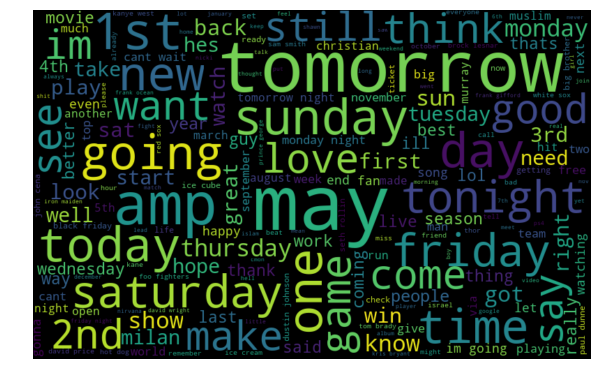

In [0]:
import matplotlib.pyplot as plt 

all_words =" ".join([" ".join(text) for text in df_train['tweets']])
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

Train the classifier with the development set to find the best hyperparameters of the algorithm. Pipeline will execute the functions sequentially.We fit the dev train data to MultinomialNB classifier.The hyperparameters to tune the algorithm are :

ngram_range: The vocabulary of the algorithm will contain (1,1)->unigrams,(1,2)-> unigram and bigrams,(1,3)->unigrams,bigrams and trigrams.It is an argument pass to CountVectorizer function that converts a collection of texts to a matrix of token counts.

use_idf:If this is true,it uses the result of CountVectorizer into TfidfTransformer that transforms a count matrix to a normalized tf or tf-idf representation.Otherwise,this is skipped.

alpha:Additive (Laplace/Lidstone) smoothing parameter.

fit_prior: Whether to learn class prior probabilities or not. If false, a uniform prior will be used.


In [0]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
X_train,Y_train = [],[]
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(["positive", "negative", "neutral"])

df_train_num=df_train.copy()

df_train_num['sentiments']=le.transform(df_train_num['sentiments'])

small_train, _ = train_test_split(df_train_num, test_size=0.8, stratify=df_train_num['sentiments'])

small_train_text=[' '.join(x) for x in small_train['tweets']]
print(small_train_text[0])
sent=small_train['sentiments']
total_train_text=[' '.join(x) for x in df_train_num['tweets']]
total_sent=df_train['sentiments']
print(total_train_text[1])
test_text=[' '.join(x[0]) for x in c_test]
target=[x[1] for x in c_test]
print "Length of dataset for grid purposes ",len(small_train_text)

friday night got new red lipstick put on nowhere go lying bed listening fleetwood mac lipstick on
iranian general says israels iron dome cant deal missiles keep talking like may end finding out
Length of dataset for grid purposes  5471


Use the optimal parameters in order to fit the training data to the MultinomialNB and then apply the test set and measure the results.

In [0]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.metrics import accuracy_score


clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB()),
])
parameters = {'vect__ngram_range': [(1, 1), (1, 2),(1,3),(2,3),(2,4),(2,5),(3,4)],
              'tfidf__use_idf': (True, False),
              'clf__alpha': (1,0.1,0.01,0.001),
              'clf__fit_prior':(True,False),
}
gs_clf = GridSearchCV(clf, parameters, n_jobs=-1)
gs_clf = gs_clf.fit(small_train_text,sent)
print 'MultinomialNB has best score of ',gs_clf.best_score_,' and best parameters ',gs_clf.best_params_


MultinomialNB has best score of  0.599524766953025  and best parameters  {'vect__ngram_range': (1, 3), 'clf__fit_prior': False, 'tfidf__use_idf': True, 'clf__alpha': 1}


In [0]:
fit_prior=gs_clf.best_params_['clf__fit_prior']
alpha=gs_clf.best_params_['clf__alpha']
mnb=MultinomialNB(fit_prior=fit_prior,alpha=alpha)
clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', mnb),
])
clf.fit(total_train_text,total_sent)
result=clf.predict(test_text)

print(metrics.classification_report(target, result,['positive','negative','neutral']))
metrics.confusion_matrix(target,result)
print 'Accuracy ',accuracy_score(result,target)

              precision    recall  f1-score   support

    positive       0.68      0.62      0.65       893
    negative       0.55      0.25      0.35       287
     neutral       0.52      0.69      0.59       738

   micro avg       0.59      0.59      0.59      1918
   macro avg       0.58      0.52      0.53      1918
weighted avg       0.60      0.59      0.58      1918

Accuracy  0.591762252346194


Calculate various metric for the algorithm:

precision: counts the true positives(how useful the results are).If the algorithm return 10 positive tweets and 5 of them are positive,the precision is 5/10=0.5.

recall: counts the false positives(how complete the results are).If the algorithm return 10 positive tweets and 5 of them are indeed positive,while all of the positive tweets are 20 then the recall is 10/20.

f1-score:The F1 score is the harmonic average of the precision and recall. Measures test accuracy of the algorithm.

In [0]:
print(metrics.classification_report(target, result,['positive','negative','neutral']))
metrics.confusion_matrix(target,result)
print 'Accuracy ',accuracy_score(result,target)

              precision    recall  f1-score   support

    positive       0.68      0.62      0.65       893
    negative       0.55      0.25      0.35       287
     neutral       0.52      0.69      0.59       738

   micro avg       0.59      0.59      0.59      1918
   macro avg       0.58      0.52      0.53      1918
weighted avg       0.60      0.59      0.58      1918

Accuracy  0.591762252346194


<h4>I decided to use the MultinomialNB algorithm as it is the one the is generally most appropriate for text sentiment analysis as it produced slightly better results without requiring excessive amount of time to be run. The features are selected based on the GridSearch and in most occassions using bigram and trigram helped improved the overal performance of the algorithm.</h4>

I chose to also continue with testing (not a part of assignment) to see how SVM behaves.

Parameters:
 

1.   C:For large values of C, the optimization will choose a smaller-margin hyperplane if that hyperplane does a better job of getting all the training points classified correctly. Conversely, a very small value of C will cause the optimizer to look for a larger-margin separating hyperplane
2.   Kernel Functions: Various Kernel functions (linear rbf polyonomial etc)



In [0]:
from sklearn.svm import SVC 
from sklearn.feature_extraction.text import TfidfVectorizer
kernels=['linear', 'poly', 'rbf', 'sigmoid']

vectorizer = TfidfVectorizer(min_df = 5,max_df = 0.8,sublinear_tf = True,use_idf = True)
train_vectors = vectorizer.fit_transform(total_train_text)
grid_vectors = vectorizer.transform(small_train_text)
test_vectors = vectorizer.transform(test_text)

parameters = {'kernel': ('linear', 'poly', 'rbf', 'sigmoid'),
              'C': [0.1,1,10,1000,10000],
}

param_grid = {'C':[1,10],'kernel':['linear', 'poly', 'rbf', 'sigmoid', 'precomputed']}

gs_clf_svc = GridSearchCV(SVC(), parameters, refit = True, verbose=2)
gs_clf_svc = gs_clf_svc.fit(grid_vectors,sent)
print 'SVC has best score of ',gs_clf_svc.best_score_,' and best parameters ',gs_clf_svc.best_params_
# print prediction results 

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] kernel=linear, C=0.1 ............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............................. kernel=linear, C=0.1, total=   2.5s
[CV] kernel=linear, C=0.1 ............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.9s remaining:    0.0s


[CV] ............................. kernel=linear, C=0.1, total=   2.6s
[CV] kernel=linear, C=0.1 ............................................
[CV] ............................. kernel=linear, C=0.1, total=   2.6s
[CV] kernel=poly, C=0.1 ..............................................


/usr/local/lib/python2.7/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[CV] ............................... kernel=poly, C=0.1, total=   2.2s
[CV] kernel=poly, C=0.1 ..............................................
[CV] ............................... kernel=poly, C=0.1, total=   2.2s
[CV] kernel=poly, C=0.1 ..............................................
[CV] ............................... kernel=poly, C=0.1, total=   2.3s
[CV] kernel=rbf, C=0.1 ...............................................
[CV] ................................ kernel=rbf, C=0.1, total=   2.5s
[CV] kernel=rbf, C=0.1 ...............................................
[CV] ................................ kernel=rbf, C=0.1, total=   2.4s
[CV] kernel=rbf, C=0.1 ...............................................
[CV] ................................ kernel=rbf, C=0.1, total=   2.5s
[CV] kernel=sigmoid, C=0.1 ...........................................
[CV] ............................ kernel=sigmoid, C=0.1, total=   2.3s
[CV] kernel=sigmoid, C=0.1 ...........................................
[CV] .

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  4.0min finished


SVC has best score of  0.6077499543045147  and best parameters  {'kernel': 'sigmoid', 'C': 10000}


In [0]:
kernel=gs_clf_svc.best_params_['kernel']
C=gs_clf_svc.best_params_['C']
svc=SVC(kernel=kernel,C=C)
svc.fit(train_vectors,total_sent)
result=svc.predict(test_vectors)

print(metrics.classification_report(target, result,['positive','negative','neutral']))
metrics.confusion_matrix(target,result)
print 'Accuracy ',accuracy_score(result,target)

              precision    recall  f1-score   support

    positive       0.75      0.49      0.60       893
    negative       0.52      0.40      0.45       287
     neutral       0.50      0.75      0.60       738

   micro avg       0.58      0.58      0.58      1918
   macro avg       0.59      0.55      0.55      1918
weighted avg       0.62      0.58      0.58      1918

Accuracy  0.5792492179353493


In [0]:
#brute force scan for all parameters, here are the tricks
#usually max_depth is 6,7,8
#learning rate is around 0.05, but small changes may make big diff
#tuning min_child_weight subsample colsample_bytree can have 
#much fun of fighting against overfit 
#n_estimators is how many round of boosting
#finally, ensemble xgboost with multiple seeds may reduce variance
from xgboost import XGBClassifier
parameters = {'objective':['multi:softmax'],
              'learning_rate': [0.05,0.1], #so called `eta` value
              'max_depth': [6,7,8],
              'min_child_weight': [11],
              'silent': [1],
              'subsample': [0.5],
              'colsample_bytree': [0.5],
              'n_estimators': [6,7,8,100], #number of trees, change it to 1000 for better results
              'seed': [1337]}
gsearch2 = GridSearchCV(estimator = XGBClassifier(num_class=3), param_grid = parameters,n_jobs=4,iid=False, cv=5)

gsearch2.fit(train_vectors,total_sent)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, num_class=3, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'n_estimators': [6, 7, 8, 100], 'subsample': [0.5], 'seed': [1337], 'colsample_bytree': [0.5], 'silent': [1], 'objective': ['multi:softmax'], 'learning_rate': [0.05, 0.1], 'max_depth': [6, 7, 8], 'min_child_weight': [11]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [0]:
gsearch2.best_params_, gsearch2.best_score_

({'colsample_bytree': 0.5,
  'learning_rate': 0.1,
  'max_depth': 8,
  'min_child_weight': 11,
  'n_estimators': 100,
  'objective': 'multi:softmax',
  'seed': 1337,
  'silent': 1,
  'subsample': 0.5},
 0.5772966267900241)

In [0]:
xgb=XGBClassifier(num_class=3,
              objective=gsearch2.best_params_['objective'],
              learning_rate=gsearch2.best_params_['learning_rate'],
              max_depth=gsearch2.best_params_['max_depth'],
              min_child_weight=gsearch2.best_params_['min_child_weight'],
              subsample=gsearch2.best_params_['subsample'],
              colsample_bytree=gsearch2.best_params_['colsample_bytree'],
              n_estimators=gsearch2.best_params_['n_estimators'],
              seed=1337
              )
xgb.fit(train_vectors,total_sent)
result=xgb.predict(test_vectors)

print(metrics.classification_report(target, result,['positive','negative','neutral']))
metrics.confusion_matrix(target,result)
print 'Accuracy ',accuracy_score(result,target)

              precision    recall  f1-score   support

    positive       0.75      0.38      0.50       893
    negative       0.62      0.09      0.16       287
     neutral       0.45      0.87      0.59       738

   micro avg       0.52      0.52      0.52      1918
   macro avg       0.61      0.45      0.42      1918
weighted avg       0.61      0.52      0.49      1918

Accuracy  0.5245046923879041


In [0]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

xgb=XGBClassifier(max_depth=5, n_estimators=1000, learning_rate=0.1)
xgb.fit(train_vectors,total_sent)

In [0]:
result = xgb.predict(test_vectors)
print(metrics.classification_report(target, result,['positive','negative','neutral']))
metrics.confusion_matrix(target,result)
print 'Accuracy ',accuracy_score(result,target)